In [ ]:
%load_ext autoreload
%autoreload 2

In [12]:
import numpy as np
import umap
import umap.plot

from uriel import Uriel

u = Uriel()
u.load()

reducer = umap.UMAP(n_neighbors=15, metric='cosine', min_dist=0.5)
trans = reducer.fit(u.knn_matrix)
# trans.embedding_  # Here are vectors for each language if needed

In [13]:
coi = [
    'Atlantic-Congo',
    'Austronesian',
    'Indo-European',
    'Afro-Asiatic',
    'Sino-Tibetan',
    'Nuclear_Trans_New_Guinea',
    'Pama-Nyungan',
    'Otomanguean',
    'Austroasiatic',
    'Semitic',
    'Dravidian',
    'Turkic',
    'Slavic',
    'Germanic',
    'Italic'
]

labels = [0 for _ in range(len(u.languages))]
for i, f in enumerate(coi):
    for j, l in enumerate(u.languages):
        if f in u.lang_fams[l]:
            labels[j] = i
            
hover_data = pd.DataFrame({
    'c': labels,
    'fam': [' '.join(u.lang_fams[l]) for l in u.languages],
#     'code': languages,
#     'lang': [isos.get(lang, lang) for lang in languages],
#     'dataset': ['ner41' if lang in ner_langs else '' for lang in languages],
})


In [14]:
# umap.plot.points(
#     trans,
#     labels=np.array(labels)
# )

from bokeh.plotting import show, save, output_notebook, output_file
import pandas as pd

p = umap.plot.interactive(
    trans,
    labels=labels,
    hover_data=hover_data,
    width=600,
    height=600,
    interactive_text_search=True,
    point_size=4,
    interactive_text_search_alpha_contrast=0.99,
    background='black'
)
output_notebook()
show(p)



Loading BokehJS ...

/root/miniconda3/lib/python3.8/site-packages/umap/plot.py:849: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


<AxesSubplot:>

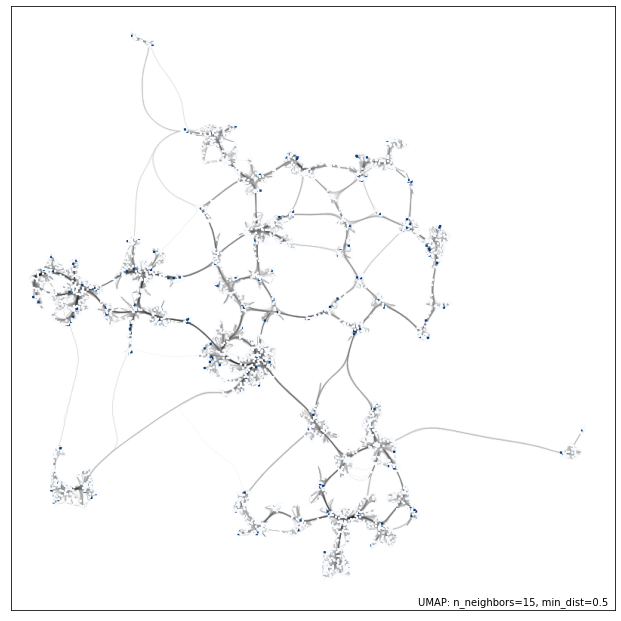

In [11]:
umap.plot.connectivity(trans, show_points=True, edge_bundling='hammer')

In [ ]:
ner_langs = [
    l2v.LETTER_CODES[line.split()[0]]
    for line
    in open('./papers/rahimi_ner.txt')
]